# Assignment 3: Time-Series Data
Group 19 - Raju Rishikesh Gollapally and Sai Sharanya Devambatla

Date - 04/07/2024

## There are some few types of timeseries tasks

## A temperature-forecasting of Jena Climate dataset

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 18:10:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.129.24, 54.231.234.8, 54.231.165.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.129.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.02MB/s    in 2.1s    

2024-04-07 18:10:49 (6.02 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Examining the data within the Jena Weather Dataset**

In [ ]:
import os # Importing the os module for file path operations
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n") # Splitting the data into lines
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines)) # Displaying the number of data points

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing and Analyzing the Data from the Jena Weather Dataset**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines): ## Iterating over each line in the dataset
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:] ## Storing the remaining data points in the raw_data array

**Visualizing the temperature over time**

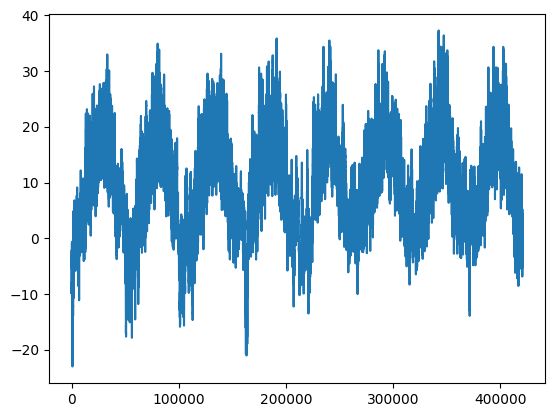

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature) ## Plotting the temperature values over time

**Displaying the temperature time series for the initial 10 days**

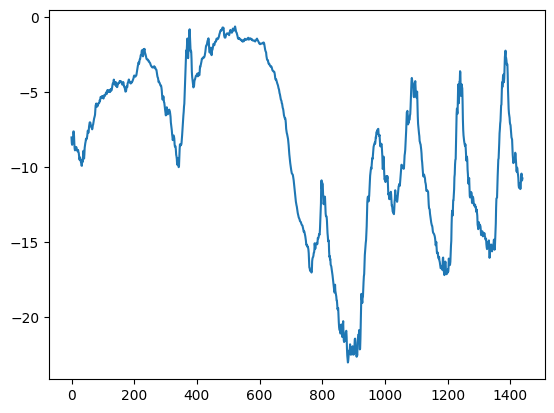

In [ ]:
plt.plot(range(1440), temperature[:1440]) # Plotting the temperature values for the first 10 days (1440 minutes)


**Calculating the number of samples to be used for each data partition**

In [ ]:
num_train_samples = int(0.5 * len(raw_data)) #Using 50% of the data for training
num_val_samples = int(0.25 * len(raw_data)) # Using 25% of the data for Validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Data Preparation

**Normalization of data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0) #Mean computation
raw_data -= mean #Subtracting the mean from the raw data
std = raw_data[:num_train_samples].std(axis=0) #Standard deviation computation
raw_data /= std #Dividing by the standard deviation to normalize the data

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10) #Creating an integer sequence
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2, # Size of each batch in the dataset
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i])) #Printing inputs and corresponding targets

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6 #Sampling rate for time series data
sequence_length = 120 #Length of each sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 #Batch size for training

# Creating training dataset
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# Creating validation dataset
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

#Creating test dataset
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Reviewing the output of one of our datasets**

In [ ]:
#Iterating over samples and targets in the training dataset
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, baseline without machine learning

**Calculating the baseline Mean Absolute Error (MAE) without using machine learning**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

## Printing the Mean Absolute Error (MAE) for validation and test datasets using the baseline method
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's experiment with a simple machine learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Defining the input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Defining callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]

# Compiling the model with optimizer, loss function, and evaluation metric
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 51s 60ms/step - loss: 12.5260 - mae: 2.7403 - val_loss: 11.0717 - val_mae: 2.6075
Epoch 2/5
819/819 [==============================] - 38s 47ms/step - loss: 9.0312 - mae: 2.3655 - val_loss: 10.8205 - val_mae: 2.5862
Epoch 3/5
819/819 [==============================] - 38s 46ms/step - loss: 8.2647 - mae: 2.2668 - val_loss: 10.2855 - val_mae: 2.5109
Epoch 4/5
819/819 [==============================] - 48s 58ms/step - loss: 7.8358 - mae: 2.2090 - val_loss: 10.2558 - val_mae: 2.5159
Epoch 5/5
405/405 [==============================] - 13s 32ms/step - loss: 11.1117 - mae: 2.6314
Test MAE: 2.63


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]

# Compile the model with optimizer, loss function, and evaluation metric
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 48s 57ms/step - loss: 13.5543 - mae: 2.8426 - val_loss: 13.9078 - val_mae: 2.9704
Epoch 2/5
819/819 [==============================] - 37s 45ms/step - loss: 8.7371 - mae: 2.3264 - val_loss: 10.9761 - val_mae: 2.6102
Epoch 3/5
819/819 [==============================] - 47s 57ms/step - loss: 7.5267 - mae: 2.1585 - val_loss: 10.7388 - val_mae: 2.6108
Epoch 4/5
819/819 [==============================] - 37s 44ms/step - loss: 6.7780 - mae: 2.0482 - val_loss: 11.3300 - val_mae: 2.6708
Epoch 5/5
405/405 [==============================] - 13s 30ms/step - loss: 11.6629 - mae: 2.6920
Test MAE: 2.69


**Visualizing Results**

<ipython-input-17-be133a31b03d>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", color="grey",linestyle="solid",label="Training Mean Absolute Error (MAE)")


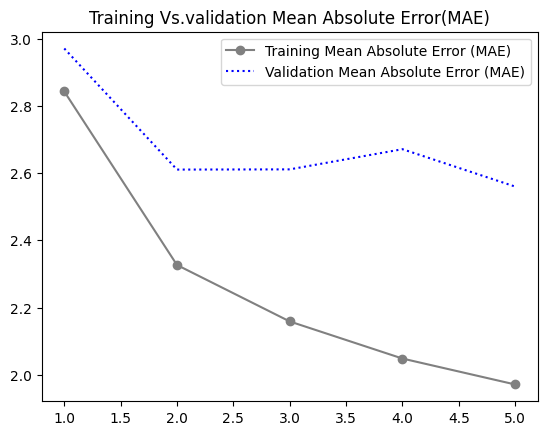

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

# Plotting training and validation MAE over epochs
plt.figure()
plt.plot(epochs, loss, "bo", color="grey",linestyle="solid",label="Training Mean Absolute Error (MAE)")
plt.plot(epochs, val_loss, "b",linestyle="dotted",label="Validation Mean Absolute Error (MAE)")
plt.title("Training Vs.validation Mean Absolute Error(MAE)")
plt.legend()
plt.show()

### Let's Experiment with a 1D Convolutional Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

# Defining callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 44s 48ms/step - loss: 24.3120 - mae: 3.8292 - val_loss: 16.8014 - val_mae: 3.2505
Epoch 2/5
819/819 [==============================] - 48s 59ms/step - loss: 15.3232 - mae: 3.1130 - val_loss: 15.9751 - val_mae: 3.1502
Epoch 3/5
819/819 [==============================] - 48s 59ms/step - loss: 14.2786 - mae: 2.9985 - val_loss: 15.2026 - val_mae: 3.0788
Epoch 4/5
819/819 [==============================] - 48s 59ms/step - loss: 13.5492 - mae: 2.9150 - val_loss: 14.9793 - val_mae: 3.0477
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 16.2741 - mae: 3.2006
Test MAE: 3.20


### An Initial Recurrent Baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 46s 53ms/step - loss: 45.2483 - mae: 4.9075 - val_loss: 13.2421 - val_mae: 2.7561
Epoch 2/5
819/819 [==============================] - 43s 52ms/step - loss: 10.9058 - mae: 2.5592 - val_loss: 9.8737 - val_mae: 2.4371
Epoch 3/5
819/819 [==============================] - 54s 65ms/step - loss: 9.6052 - mae: 2.4144 - val_loss: 9.8616 - val_mae: 2.4196
Epoch 4/5
819/819 [==============================] - 42s 51ms/step - loss: 9.2267 - mae: 2.3641 - val_loss: 9.7727 - val_mae: 2.4128
Epoch 5/5
405/405 [==============================] - 13s 32ms/step - loss: 10.3632 - mae: 2.5316
Test MAE: 2.53


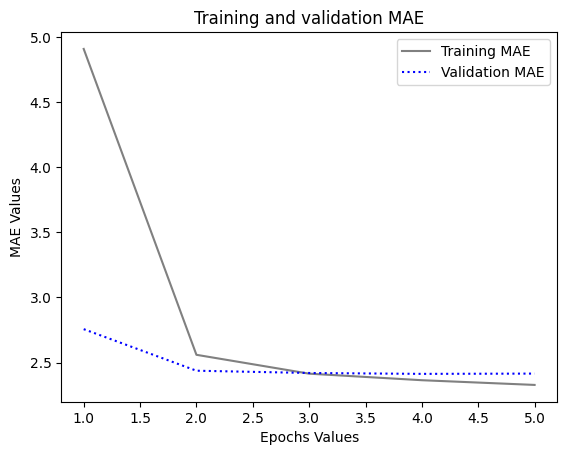

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

# Plotting training and validation MAE over epochs
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

##Recognizing recurrent neural networks

**A basic RNN implemented in NumPy**

In [ ]:
import numpy as np

## Define the dimensions and initialize random input data, state, weights, and biases
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

## Iterate through each timestep and compute outputs using tanh activation function
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A Keras Recurrent Layer

**Processing sequences of arbitrary length is possible with an RNN layer**

In [ ]:
num_features = 14 # Number of input features
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**A layer of RNN that only provides the most recent output step**

In [ ]:
num_features = 14 # Number of input features
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**A layer of RNN that provides the whole output sequence**

In [ ]:
num_features = 14 # Number of input features
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking Recurrent Layers**

In [ ]:
# Define the input shape with number of time steps and features
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Extensive application of recurrent neural networks

### Recurrent dropout as a weapon against overfitting

**Training and Evaluating a Dropout-Regularized Long Short-Term Memory (LSTM) Model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)

# Define callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 313s 376ms/step - loss: 49.4346 - mae: 5.2373 - val_loss: 13.9105 - val_mae: 2.8167
Epoch 2/5
819/819 [==============================] - 301s 367ms/step - loss: 20.0350 - mae: 3.4396 - val_loss: 10.2371 - val_mae: 2.4855
Epoch 3/5
819/819 [==============================] - 300s 366ms/step - loss: 18.2011 - mae: 3.2834 - val_loss: 9.6494 - val_mae: 2.4299
Epoch 4/5
819/819 [==============================] - 299s 365ms/step - loss: 17.3392 - mae: 3.2040 - val_loss: 9.3746 - val_mae: 2.3936
Epoch 5/5
819/819 [==============================] - 305s 372ms/step - loss: 16.6648 - mae: 3.1416 - val_loss: 9.3390 - val_mae: 2.3888


405/405 [==============================] - 29s 71ms/step - loss: 10.8095 - mae: 2.5761
Test MAE: 2.58


 **Visualizing Results of Dropout-Regularized LSTM**

<ipython-input-27-be133a31b03d>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", color="grey",linestyle="solid",label="Training Mean Absolute Error (MAE)")


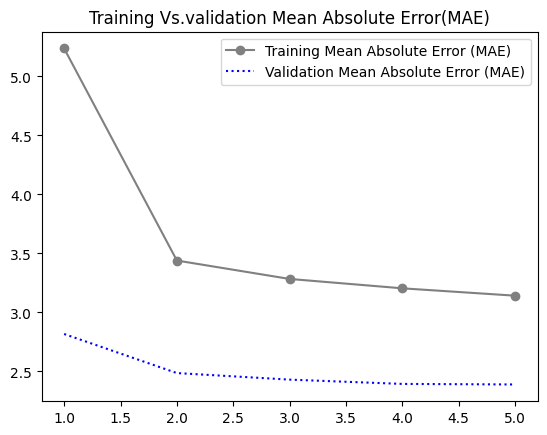

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

# Plotting training and validation MAE over epochs
plt.figure()
plt.plot(epochs, loss, "bo", color="grey",linestyle="solid",label="Training Mean Absolute Error (MAE)")
plt.plot(epochs, val_loss, "b",linestyle="dotted",label="Validation Mean Absolute Error (MAE)")
plt.title("Training Vs.validation Mean Absolute Error(MAE)")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers on top of each other.

**Training and assessing a GRU model with dropout regularization and stacked layers.**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 537s 650ms/step - loss: 24.4685 - mae: 3.6555 - val_loss: 9.4444 - val_mae: 2.3750
Epoch 2/5
819/819 [==============================] - 547s 667ms/step - loss: 14.0290 - mae: 2.9000 - val_loss: 9.1717 - val_mae: 2.3512
Epoch 3/5
819/819 [==============================] - 534s 652ms/step - loss: 13.3126 - mae: 2.8256 - val_loss: 8.9355 - val_mae: 2.3108
Epoch 4/5
819/819 [==============================] - 527s 644ms/step - loss: 12.7745 - mae: 2.7694 - val_loss: 9.3114 - val_mae: 2.3643
Epoch 5/5
819/819 [==============================] - 527s 643ms/step - loss: 12.2870 - mae: 2.7192 - val_loss: 9.2847 - val_mae: 2.3604


405/405 [==============================] - 41s 100ms/step - loss: 9.9159 - mae: 2.4523
Test MAE: 2.45


### Utilizing RNNs with bidirectional functionality.

**Training and assessing an LSTM model with bidirectional architecture**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}") # Print the test MAE

Epoch 1/5
819/819 [==============================] - 46s 53ms/step - loss: 28.5083 - mae: 3.8479 - val_loss: 10.9141 - val_mae: 2.5568
Epoch 2/5
819/819 [==============================] - 42s 51ms/step - loss: 9.7443 - mae: 2.4408 - val_loss: 9.9800 - val_mae: 2.4506
Epoch 3/5
819/819 [==============================] - 44s 53ms/step - loss: 8.8260 - mae: 2.3157 - val_loss: 10.2503 - val_mae: 2.4823
Epoch 4/5
819/819 [==============================] - 51s 62ms/step - loss: 8.3326 - mae: 2.2456 - val_loss: 10.5198 - val_mae: 2.5123
Epoch 5/5
405/405 [==============================] - 13s 32ms/step - loss: 11.1938 - mae: 2.6457
Test MAE: 2.65


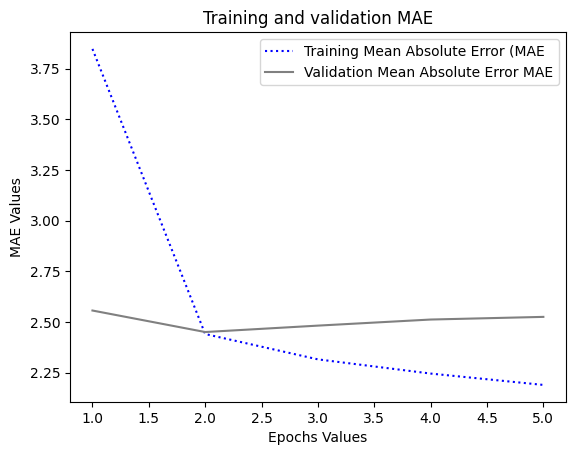

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

# Plotting training and validation MAE over epochs
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training Mean Absolute Error (MAE")
plt.plot(epochs, val_loss, color="grey", linestyle="solid", label="Validation Mean Absolute Error MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show() # Displaying the plot

In [ ]:
# Concatenate the outputs from convolutional and LSTM layers
combined = layers.concatenate([conv_x, lstm_x])
outputs = layers.Dense(1)(combined)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 47s 53ms/step - loss: 7.6188 - mae: 2.1518 - val_loss: 10.5738 - val_mae: 2.5246
Epoch 2/5
819/819 [==============================] - 43s 52ms/step - loss: 7.4182 - mae: 2.1234 - val_loss: 10.6923 - val_mae: 2.5369
Epoch 3/5
819/819 [==============================] - 45s 54ms/step - loss: 7.1618 - mae: 2.0886 - val_loss: 10.8558 - val_mae: 2.5580
Epoch 4/5
819/819 [==============================] - 43s 52ms/step - loss: 6.9059 - mae: 2.0518 - val_loss: 10.9720 - val_mae: 2.5633
Epoch 5/5
405/405 [==============================] - 14s 33ms/step - loss: 11.4442 - mae: 2.6628
Test MAE: 2.66


**Visualizing the results of the combined model**

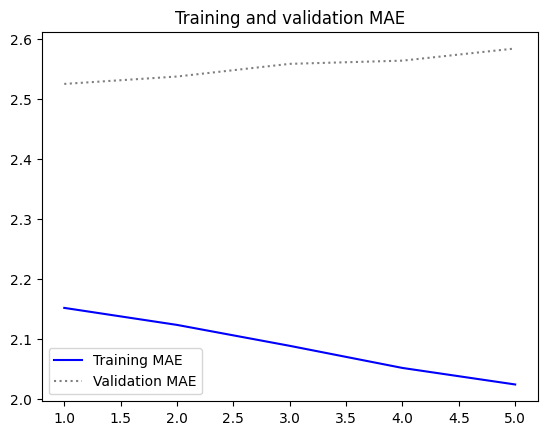

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

# Plotting training and validation MAE over epochs
plt.figure()
plt.plot(epochs, loss,color="blue",linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, "grey",linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show() # Displaying the plot